In [1]:
import openeo
from openeo.processes import ProcessBuilder
import os
import pyrosm
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geowombat as gw
import pickle
from skimage import exposure

In [15]:
# global parameters
BUILDINGS_PATH = './building_maps/'
# CITIES = ['Aachen','Aarhus','Berlin','Copenhague','Cordoba','Helsinki','Leipzig','Porto','Potsdam','Reims']
CITIES = ['test_pbf']
# CITIES = ['Potsdam']
IMAGE_DATA_PATH = './image_data/'

# OUTDATED
RGB_COL = {
    0.4924: [0.0, 0.0, 1.0, 1.0],  # Assign blue to band B02
    0.5598: [0.0, 1.0, 0.0, 1.0],  # Assign green to band B03
    0.6646: [1.0, 0.0, 0.0, 1.0]   # Assign red to band B04
}

NIRGB_COL = {
        0.4924: [0.0, 0.0, 1.0, 1.0],  # Assign blue to band B02
        0.5598: [0.0, 1.0, 0.0, 1.0],  # Assign green to band B03
        0.8328: [1.0, 0.0, 0.0, 1.0]   # Assign red to band B08
}

In [16]:
def download_OSM(city, path=BUILDINGS_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    city_map = pyrosm.get_data(city, directory=path, update=True)
    return city_map

def read_buildings(map, city, path= IMAGE_DATA_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
        
    osm = pyrosm.OSM(map)
    buildings = osm.get_buildings()
    print(f'building map for {city} downloaded')
    coordinates = buildings.geometry.total_bounds
    return coordinates, buildings

In [17]:
def run_job(results, path=IMAGE_DATA_PATH):   
    for result in results:
        file_path = os.path.join(path, result[1])
        job = result[0].create_job()
        job.start_and_wait()
        job.get_results().download_file(file_path)

In [18]:
# OUTDATED
# PNG color conversion: define child process, use ProcessBuilder
def scale_function(x: ProcessBuilder):
    return x.linear_scale_range(0, 6000, 0, 255)

In [19]:
# OUTDATED
def download_sat(coordinates, city, path=IMAGE_DATA_PATH):
    
    # establish backend connection
    connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")

    # authentication
    print("Authenticate with OIDC authentication")
    connection.authenticate_oidc()

    datacube = connection.load_collection(
      'SENTINEL2_L1C',
      spatial_extent={"west": coordinates[0], "south": coordinates[1], "east": coordinates[2], "north": coordinates[3]},
      temporal_extent=["2023-03-01", "2023-07-01"],
      max_cloud_cover=30,
      bands=['B02', 'B03', 'B04', 'B08'] # B, G, R, infrared
    )

    # take max for each pixel over time to obtain one image
    rgb_datacube = datacube.filter_bands(bands = ['B02', 'B03', 'B04'])
    rgb = rgb_datacube.mean_time()
    nirgb_datacube = datacube.filter_bands(bands = ['B02', 'B03', 'B08'])
    nirgb = nirgb_datacube.mean_time()
    b_datacube = datacube.filter_bands(bands = ['B02'])
    b = b_datacube.mean_time()
    g_datacube = datacube.filter_bands(bands = ["B03"])
    g = g_datacube.mean_time()
    r_datacube = datacube.filter_bands(bands = ["B04"])
    r = r_datacube.mean_time()
    nir_datacube = datacube.filter_bands(bands = ["B08"])
    nir = nir_datacube.mean_time()

    # scale pixels linearly
    rgb_lin = rgb.apply(scale_function)
    nirgb_lin = nirgb.apply(scale_function)
    b_lin = b.apply(scale_function)
    g_lin = g.apply(scale_function)
    r_lin = r.apply(scale_function)
    nir_lin = nir.apply(scale_function)
    
    RGB = rgb_lin.save_result(format="PNG", options={"colormap": RGB_COL})
    NIRGB = nirgb_lin.save_result(format = "PNG", options = {"colormap": NIRGB_COL})
    R = r_lin.save_result(format = "PNG")
    G = g_lin.save_result(format = "PNG")
    B = b_lin.save_result(format = "PNG")
    NIR = nir_lin.save_result(format = 'PNG')
    
    results =[[RGB, f"{city}_RGB.png"], [NIRGB,f"{city}_NIRGB.png"], [R, f"{city}_R.png"], [G, f"{city}_G.png"], [B, f"{city}_B.png"], [NIR, f'{city}_NIR.png']]

    if not os.path.isdir(path):
        os.makedirs(path)
    # run jobs for all bands
    run_job(results, path)

In [20]:
# download GTiff
def download_sat(coordinates, city, path=IMAGE_DATA_PATH):
    # establish backend connection
    connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")

    # authentication
    print("Authenticate with OIDC authentication")
    connection.authenticate_oidc()

    datacube = connection.load_collection(
      'SENTINEL2_L1C',
      spatial_extent={"west": coordinates[0], "south": coordinates[1], "east": coordinates[2], "north": coordinates[3]},
      temporal_extent=["2023-03-01", "2023-07-01"],
      max_cloud_cover=30,
      bands=['B02', 'B03', 'B04', 'B08'] # B, G, R, infrared
    )

    # take mean of the bands
    datacube_mean = datacube.mean_time()
    
    result = datacube_mean.save_result(format="GTiff")
    
    if not os.path.isdir(path):
        os.makedirs(path)
    file_path = os.path.join(path, f'{city}.tif')
    job = result.create_job()
    job.start_and_wait()
    job.get_results().download_file(file_path)

In [21]:
def rasterize_buildings(src, building_map):
    building_raster = rasterio.features.rasterize(
        shapes=building_map.geometry,
        out_shape=(src.shape[1],src.shape[2]),
        transform=src.transform,
        fill=0,
        all_touched=True,
        dtype=rasterio.uint8
    )
    #print(building_raster.shape)
    #plt.imshow(building_raster, cmap='gray')
    return building_raster    

In [22]:
# OUTDATED
def overlay(build_map, sat_img, path=IMAGE_DATA_PATH):
    satellite_img = plt.imread(sat_img)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_axis_off()
    
    img_extent = [build_map.total_bounds[0], build_map.total_bounds[2], 
              build_map.total_bounds[1], build_map.total_bounds[3]]
    
    ax.imshow(satellite_img, cmap='grey', alpha=1, zorder=1)
    print(type(build_map.geometry))
    build_map.plot(ax=ax, alpha=1, zorder=2)
    plt.show()
    

In [23]:
def plot_image_data(image_data):
    # image_data = {'Buildings':building_map, 'Buildings_raster':building_raster,'RGB':rgb, 'NIRGB':nirgb, 'R':r, 'G':g, 'B':b, 'NIR':nir}
    
    fig = plt.figure(figsize=(18,12))
    ax_list = fig.subplots(2,4) 
    
    # plot overlapping buildings
    image_data['Buildings'].plot(ax=ax_list[0][0], alpha=1, zorder=2)
    image_data['R'].plot(ax=ax_list[0][0], alpha=1, cmap='grey', zorder=1, add_colorbar=False)
    
    # plot buildings
    image_data['Buildings'].plot(ax=ax_list[0][1])

    # plot RGB
    image_data['RGB'].gw.imshow(robust=True, flip=False, ax=ax_list[0][2])
    
    # plot NIRGB
    image_data['NIRGB'].gw.imshow(robust=True, flip=False, ax=ax_list[0][3])

    # plot singe channels
    image_data['R'].plot(ax=ax_list[1][0], cmap='grey', add_colorbar=False)
    image_data['G'].plot(ax=ax_list[1][1], cmap='grey', add_colorbar=False)
    image_data['B'].plot(ax=ax_list[1][2], cmap='grey', add_colorbar=False)
    image_data['NIR'].plot(ax=ax_list[1][3], cmap='grey', add_colorbar=False)
    
    for title, ax in zip(image_data.keys(),ax_list.flatten()):
        ax.set_title(title)
        ax.title.set_fontsize(14)
        ax.axis('off')
        ax.set_aspect('equal')  
        
    plt.tight_layout()
    plt.show()

In [24]:
def save_data(image_data, path, city):
    # save dictionary as pkl
    file_name = f'{city}.pkl'

    with open(os.path.join(path, file_name), 'wb') as file:
        pickle.dump(image_data, file)
    print(f'dataset {city} written')

In [25]:
def color_correct(r, g, b, channels):
    return channels[0]*r, channels[1]*g, channels[2]*b

In [26]:
def img_preprocess(city, building_map, path=IMAGE_DATA_PATH):
    file_path = os.path.join(path, f'{city}.tif' )
    
    with gw.config.update(sensor="bgrn"):
        with gw.open(file_path) as src:
            # match image crs
            building_map = building_map.to_crs(src.crs) 
            
            # create rgb 
            rgb = src.where(src != 0).sel(band=["red", "green", "blue"])
            # histogram equalization: rgb.values gives the np.array
            rgb.values = exposure.equalize_hist(rgb.values)
            
            # manually correct color values
            rgb.values[0],rgb.values[1], rgb.values[2] = color_correct(0.91, 1, 0.90, rgb.values)
            
            # create nirgb
            nirgb = src.where(src != 0).sel(band=["nir", "green", "blue"])
            # histogram equalization
            nirgb.values = exposure.equalize_hist(nirgb.values)
            # r
            r = src.where(src != 0).sel(band=['red'])
            # histogram equalization
            r.values = exposure.equalize_hist(r.values)
            # g
            g = src.where(src != 0).sel(band=['green'])
            # histogram equalization
            g.values = exposure.equalize_hist(g.values)
            # b
            b = src.where(src != 0).sel(band=['blue'])
            # histogram equalization
            b.values = exposure.equalize_hist(b.values)
            # nir
            nir = src.where(src != 0).sel(band=['nir'])
            # histogram equalization
            nir.values = exposure.equalize_hist(nir.values)
            
            # rasterize buildings
            building_raster = rasterize_buildings(src, building_map)
            
            # create dictionary with image data for plotting
            image_plot = {'Buildings overlay':building_map, 'Buildings':building_map,'RGB':rgb, 'NIRGB':nirgb, 'R':r, 'G':g, 'B':b, 'NIR':nir}
            
            # dictionary with image data for saving
            image_data = {'RGB':rgb, 'NIRGB':nirgb, 'R':r, 'G':g, 'B':b, 'NIR':nir, 'Buildings':building_raster}
            
            # save dictionary as pkl
            save_data(image_data, path, city)
            
            # call plot function:
            plot_image_data(image_plot)

In [27]:
for city in CITIES:
    city_map = download_OSM(city)
    city_coord, building_map = read_buildings(city_map, city)
    #print(f"Bounding box of {city}: {city_coord}")
    download_sat(city_coord, city)
    img_preprocess(city, building_map)

building map for test_pbf downloaded
Authenticate with OIDC authentication
Authenticated using refresh token.
0:00:00 Job 'j-2405108563094768bbad495b72bbf346': send 'start'


KeyboardInterrupt: 

In [1]:
# ConvNet
import matplotlib.pyplot as plt
import numpy as np

# Data for the raw trained model
raw_model_metrics = {
    'F1-score': 0.35,
    'Precision': 0.27,
    'Recall': 0.50,
    'Accuracy': 0.55
}

# Data for the tuned model
tuned_model_metrics = {
    'F1-score': 0.68,
    'Precision': 0.76,
    'Recall': 0.69,
    'Accuracy': 0.71,
}

# Convert the data into lists
metrics = list(raw_model_metrics.keys())
raw_values = list(raw_model_metrics.values())
tuned_values = list(tuned_model_metrics.values())

# Define the position of the bars on the x-axis
x = np.arange(len(metrics))

# Define the width of the bars
width = 0.35

# Create the figure and axes objects with a smaller plot size
fig, ax = plt.subplots(figsize=(8, 4.5))  # Adjusted width to accommodate legend

# Plot the bar charts with specified colors
bars1 = ax.bar(x - width/2, raw_values, width, color='#d9534f', label='No Optimization')  # Deep orange-red
bars2 = ax.bar(x + width/2, tuned_values, width, color='#f7bc9e', label='Hyperparameter Optimization')  # Muted orange-red

# Remove the black border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Increase font size of labels and ticks
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('Score', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=14)

# Function to add labels at the bottom of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=14)

# Add labels at the bottom of bars
add_labels(bars1)
add_labels(bars2)

# Adjust legend position to bottom without border
ax.legend(fontsize=14, loc='lower center', bbox_to_anchor=(0.5, -0.3), frameon=False, shadow=True, ncol=2)

# Save the plot as a PNG file
plt.tight_layout()
plt.savefig('../results/compare_metrics.png', dpi=300)  # Save with higher resolution for better quality
plt.show()


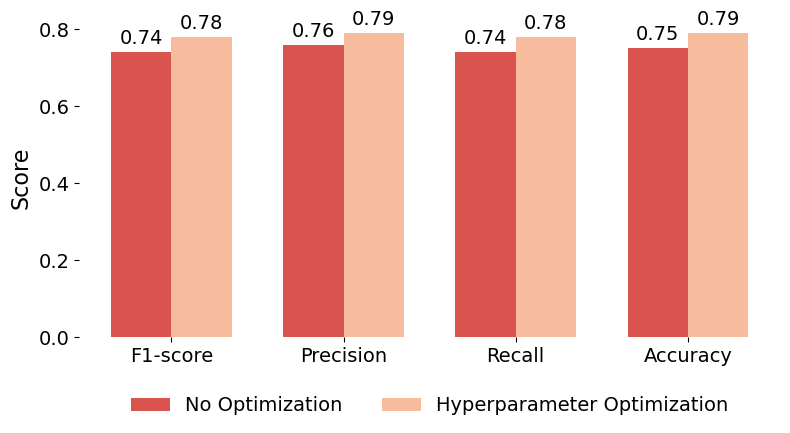

In [3]:
# UNet
import matplotlib.pyplot as plt
import numpy as np

# Data for the raw trained model
raw_model_metrics = {
    'F1-score': 0.74,
    'Precision': 0.76,
    'Recall': 0.74,
    'Accuracy': 0.75
}

# Data for the tuned model
tuned_model_metrics = {
    'F1-score': 0.78,
    'Precision': 0.79,
    'Recall': 0.78,
    'Accuracy': 0.79,
}

# Convert the data into lists
metrics = list(raw_model_metrics.keys())
raw_values = list(raw_model_metrics.values())
tuned_values = list(tuned_model_metrics.values())

# Define the position of the bars on the x-axis
x = np.arange(len(metrics))

# Define the width of the bars
width = 0.35

# Create the figure and axes objects with a smaller plot size
fig, ax = plt.subplots(figsize=(8, 4.5))  # Adjusted width to accommodate legend

# Plot the bar charts with specified colors
bars1 = ax.bar(x - width/2, raw_values, width, color='#d9534f', label='No Optimization')  # Deep orange-red
bars2 = ax.bar(x + width/2, tuned_values, width, color='#f7bc9e', label='Hyperparameter Optimization')  # Muted orange-red

# Remove the black border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Increase font size of labels and ticks
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('Score', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=14)

# Function to add labels at the bottom of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=14)

# Add labels at the bottom of bars
add_labels(bars1)
add_labels(bars2)

# Adjust legend position to bottom without border
ax.legend(fontsize=14, loc='lower center', bbox_to_anchor=(0.5, -0.3), frameon=False, shadow=True, ncol=2)

# Save the plot as a PNG file
plt.tight_layout()
plt.savefig('../results/compare_metrics_unet.png', dpi=300)  # Save with higher resolution for better quality
plt.show()
